# Neural Network Models
Using the labelled Lichess data, this notebook will attempt to find a regression neural network which can fit that labelled data.

## Pre-requisites

### If running on Google Collab
If not running on Google collab do not run these next two cells!

In [1]:
# Install the only dependency not available from collab directly
!pip install chess

# Get imported files from repo
!git clone -b lichess-neural-networks https://github.com/owenjaques/chessbot.git
!mv chessbot chessbot-repo
!mv chessbot-repo/neural_networks/chessbot .
!rm chessbot-repo -r

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 KB 2.9 MB/s eta 0:00:00
Cloning into 'chessbot'...
remote: Enumerating objects: 588, done.
remote: Counting objects: 100% (283/283), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 588 (delta 93), reused 187 (delta 57), pack-reused 305
Receiving objects: 100% (588/588), 63.43 MiB | 7.82 MiB/s, done.
Resolving deltas: 100% (285/285), done.


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
working_directory = '/content/gdrive/MyDrive/chessbot_weights/'
data_directory = working_directory

Mounted at /content/gdrive


### If not running on Google Collab
Set the weights directory variable to wherever you would like data saved.

In [ ]:
!mkdir -p bin
working_directory = './bin'
data_directory = '../pre_processing/data'

### Imports

In [17]:
import chess
import chess.pgn
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import math
import os
import threading
from chessbot import modelinput

### Data generator For Keras

In [4]:
# There is a wierd bug here where more than one worker will cause the input data to get slightly
# messed up, however, using 1 worker seems to be infinitely faster than running this in a loop,
# which is super odd, but I'm not complaining.
def worker(input, output, input_type, start_index, num):
    input_generator = modelinput.ModelInput(input_type)
    
    if input_type == 'all':
        for i in range(num):
            output[0][start_index + i], output[1][start_index + i], output[2][start_index + i] = input_generator.get_input_from_fen(input[start_index + i])
    else:
        for i in range(num):
            output[start_index + i] = input_generator.get_input_from_fen(input[start_index + i])

    print(f'\rThread {start_index // num} completed processing {num} samples.', end='')

class DataGenerator(keras.utils.Sequence):
    def __init__(self, data_file, input_type, batch_size=32, pre_process=True, save_file=None, workers=1):
        self.batch_size = batch_size
        data = np.load(data_file, allow_pickle=True)
        self.y = data['y']
        self.n = len(self.y)
        self.input_type = input_type

        if pre_process:
            input_size = modelinput.ModelInput(input_type).input_length()
            
            if input_type == 'all':
                self.X = []
                self.X.append(np.full((self.n, int(input_size[0])), -1.0))
                self.X.append(np.full((self.n, int(input_size[1])), -1.0))
                self.X.append(np.full((self.n, int(input_size[2])), -1.0))
            else:
                self.X = np.full((self.n, input_size), -1.0)

            step = self.n // workers

            threads = []
            for i in range(0, self.n, step):
                threads.append(threading.Thread(target=worker, args=(data['X'], self.X, input_type, i, step)))
                threads[-1].start()

            for i in range(workers):
                threads[i].join()
            
            if save_file != None:
                np.savez_compressed(save_file, X=self.X, y=self.y)
        else:
            self.X = data['X']

    def __len__(self):
        return math.ceil(self.n / self.batch_size)

    def __getitem__(self, idx):
        # Returns one batch of data
        low = idx * self.batch_size
        high = np.minimum(low + self.batch_size, self.n)
        
        if self.input_type == 'all':
            return [self.X[0][low:high], self.X[1][low:high], self.X[2][low:high]], self.y[low:high]
        
        return self.X[low:high], self.y[low:high]

## Setting up the Models

### Model with one input

#### Pre-process the data

In [5]:
single_input_training_data = DataGenerator(data_directory + '/training_set.npz', 'positions')
single_input_validation_data = DataGenerator(data_directory + '/validation_set.npz', 'positions')

Thread 0 completed processing 12500 samples.

##### Sanity check
Here we check that the training data was transformed correctly. X and y should both be in the range [0, 1].

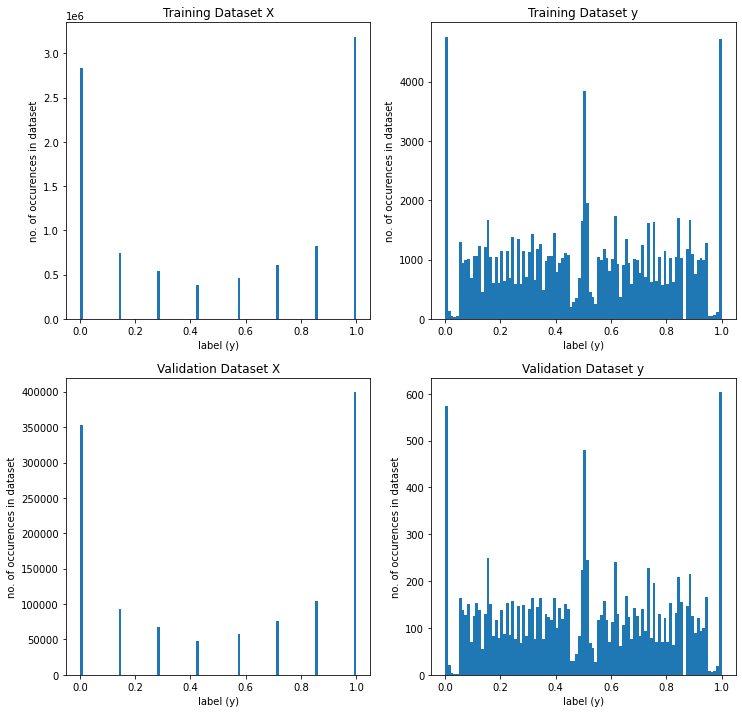

In [6]:
def sanity_check_single_input(training_data, validation_data):
    _, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

    ax[0, 0].hist(training_data.X.flatten(), bins=100)
    ax[0, 0].set_title(f'Training Dataset X')
    ax[0, 0].set_xlabel('label (y)')
    ax[0, 0].set_ylabel('no. of occurences in dataset')

    ax[0, 1].hist(training_data.y, bins=100)
    ax[0, 1].set_title(f'Training Dataset y')
    ax[0, 1].set_xlabel('label (y)')
    ax[0, 1].set_ylabel('no. of occurences in dataset')

    ax[1, 0].hist(validation_data.X.flatten(), bins=100)
    ax[1, 0].set_title(f'Validation Dataset X')
    ax[1, 0].set_xlabel('label (y)')
    ax[1, 0].set_ylabel('no. of occurences in dataset')

    ax[1, 1].hist(validation_data.y, bins=100)
    ax[1, 1].set_title(f'Validation Dataset y')
    ax[1, 1].set_xlabel('label (y)')
    ax[1, 1].set_ylabel('no. of occurences in dataset')

    plt.show()

sanity_check_single_input(single_input_training_data, single_input_validation_data)

##### Reduce the number of samples that are ~50% to further balance the dataset

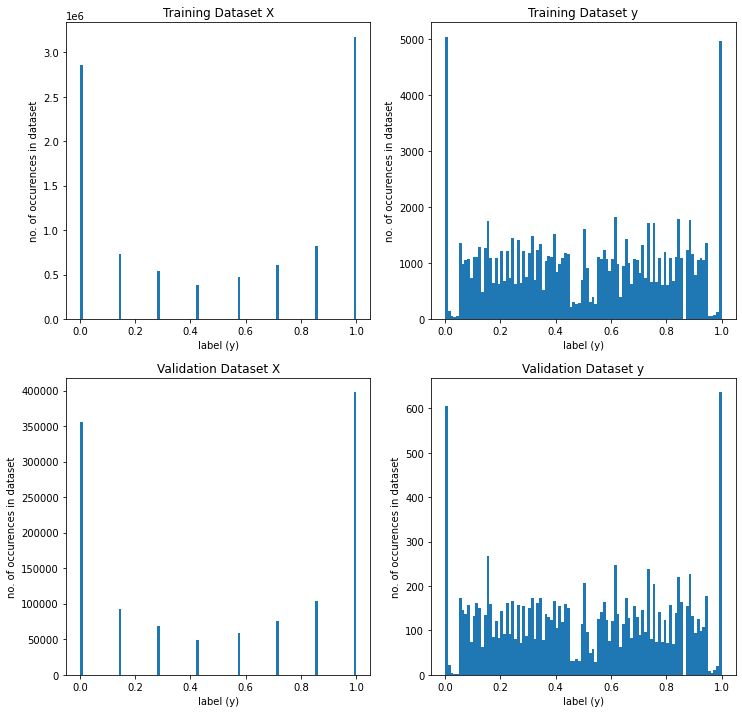

In [7]:
for i in range(single_input_training_data.n):
    if 0.475 < single_input_training_data.y[i] < 0.525:
        if np.random.rand() < 0.6:
            index = math.floor((np.random.rand() * single_input_training_data.n))
            single_input_training_data.y[i] = single_input_training_data.y[index]
            single_input_training_data.X[i] = single_input_training_data.X[index]

for i in range(single_input_validation_data.n):
    if 0.475 < single_input_validation_data.y[i] < 0.525:
        if np.random.rand() < 0.6:
            index = math.floor((np.random.rand() * single_input_validation_data.n))
            single_input_validation_data.y[i] = single_input_validation_data.y[index]
            single_input_validation_data.X[i] = single_input_validation_data.X[index]

sanity_check_single_input(single_input_training_data, single_input_validation_data)

#### Model Network

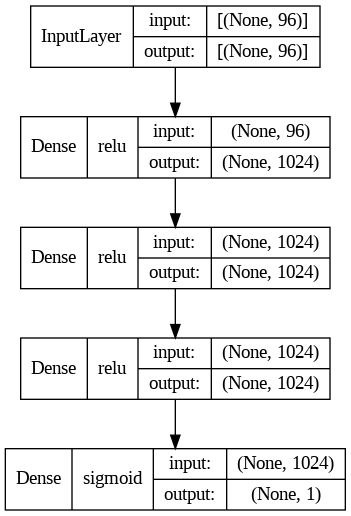

In [19]:
single_input_model = keras.Sequential([
	keras.layers.Input(modelinput.ModelInput('positions').input_length()),
	keras.layers.Dense(1024, activation='relu'),
	keras.layers.Dense(1024, activation='relu'),
	keras.layers.Dense(1024, activation='relu'),
	keras.layers.Dense(1, activation='sigmoid')
])

single_input_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
	metrics=[keras.metrics.MeanAbsoluteError()]
)

keras.utils.plot_model(single_input_model, show_shapes=True, show_layer_activations=True, to_file='single_input_model.png', show_layer_names=False)

### Model with three inputs
This will test a model with three different inputs, whose network is based on the network from the Giraffe Chess engine (accessible https://arxiv.org/abs/1509.01549).

#### Pre-process the Data

In [9]:
triple_input_training_data = DataGenerator(data_directory + '/training_set.npz', 'all')
triple_input_validation_data = DataGenerator(data_directory + '/validation_set.npz', 'all')

Thread 0 completed processing 12500 samples.

##### Sanity Check
Like the above model we will check that the dataset has been correctly processed and is in the range [0, 1].

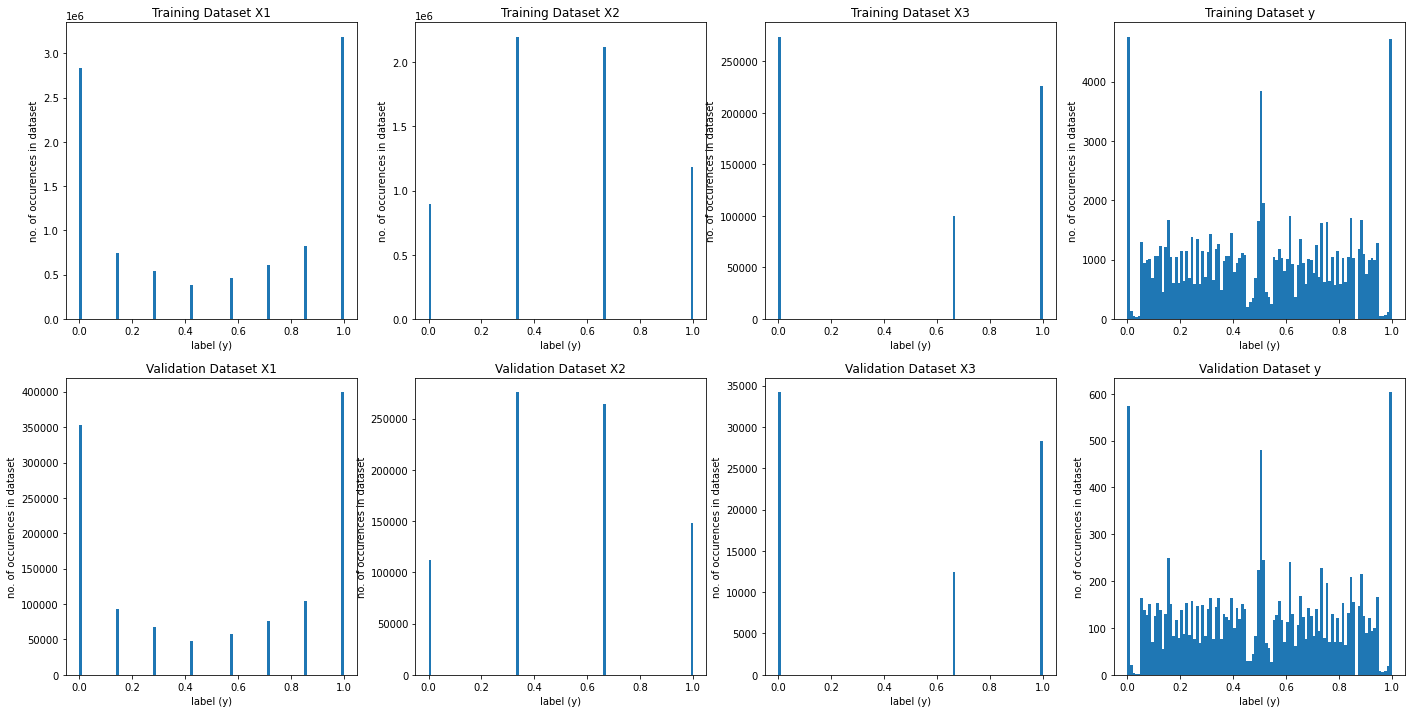

In [10]:
def sanity_check_triple_input(training_data, validation_data):
    _, ax = plt.subplots(nrows=2, ncols=4, figsize=(24, 12))

    ax[0, 0].hist(training_data.X[0].flatten(), bins=100)
    ax[0, 0].set_title(f'Training Dataset X1')
    ax[0, 0].set_xlabel('label (y)')
    ax[0, 0].set_ylabel('no. of occurences in dataset')

    ax[0, 1].hist(training_data.X[1].flatten(), bins=100)
    ax[0, 1].set_title(f'Training Dataset X2')
    ax[0, 1].set_xlabel('label (y)')
    ax[0, 1].set_ylabel('no. of occurences in dataset')

    ax[0, 2].hist(training_data.X[2].flatten(), bins=100)
    ax[0, 2].set_title(f'Training Dataset X3')
    ax[0, 2].set_xlabel('label (y)')
    ax[0, 2].set_ylabel('no. of occurences in dataset')

    ax[0, 3].hist(training_data.y, bins=100)
    ax[0, 3].set_title(f'Training Dataset y')
    ax[0, 3].set_xlabel('label (y)')
    ax[0, 3].set_ylabel('no. of occurences in dataset')

    ax[1, 0].hist(validation_data.X[0].flatten(), bins=100)
    ax[1, 0].set_title(f'Validation Dataset X1')
    ax[1, 0].set_xlabel('label (y)')
    ax[1, 0].set_ylabel('no. of occurences in dataset')

    ax[1, 1].hist(validation_data.X[1].flatten(), bins=100)
    ax[1, 1].set_title(f'Validation Dataset X2')
    ax[1, 1].set_xlabel('label (y)')
    ax[1, 1].set_ylabel('no. of occurences in dataset')

    ax[1, 2].hist(validation_data.X[2].flatten(), bins=100)
    ax[1, 2].set_title(f'Validation Dataset X3')
    ax[1, 2].set_xlabel('label (y)')
    ax[1, 2].set_ylabel('no. of occurences in dataset')

    ax[1, 3].hist(validation_data.y, bins=100)
    ax[1, 3].set_title(f'Validation Dataset y')
    ax[1, 3].set_xlabel('label (y)')
    ax[1, 3].set_ylabel('no. of occurences in dataset')

    plt.show()

sanity_check_triple_input(triple_input_training_data, triple_input_validation_data)

##### Reduce the number of samples that are ~50% to further balance the dataset



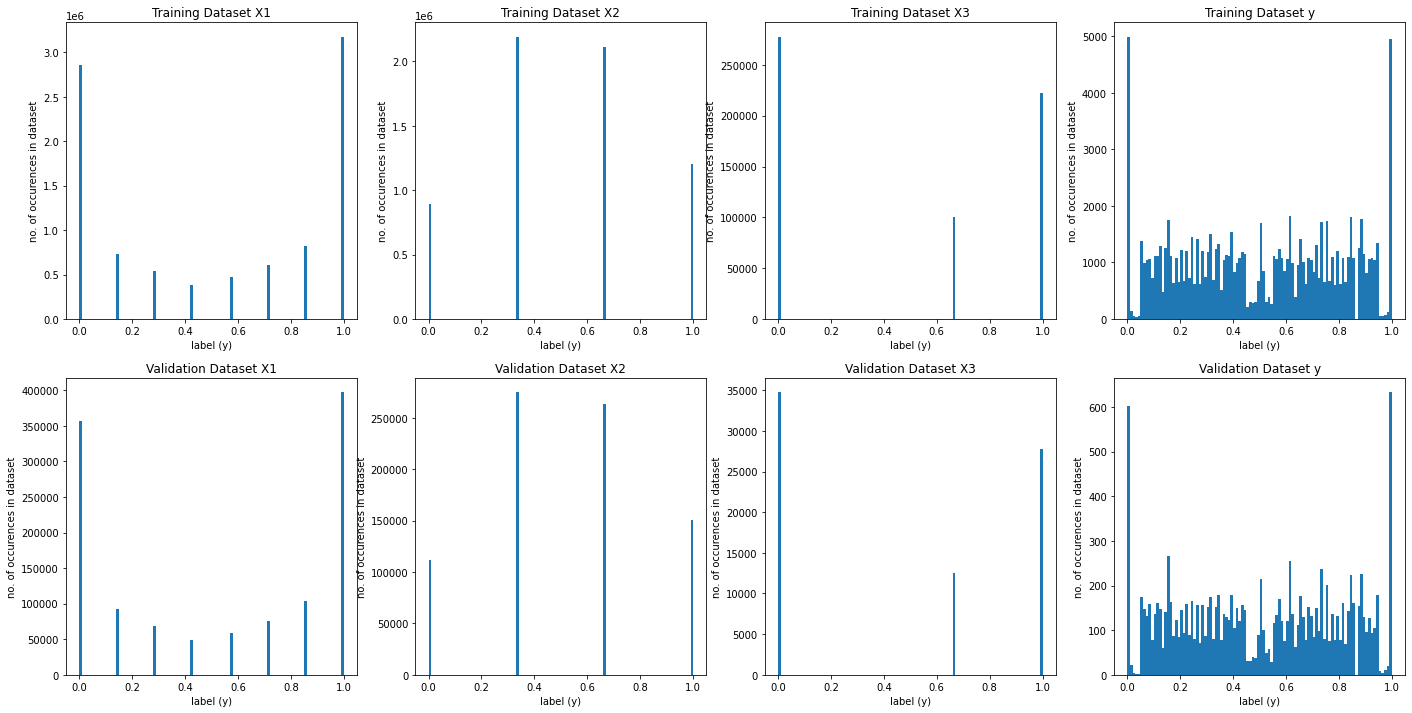

In [11]:
for i in range(triple_input_training_data.n):
    if 0.475 < triple_input_training_data.y[i] < 0.525:
        if np.random.rand() < 0.6:
            index = math.floor((np.random.rand() * triple_input_training_data.n))
            triple_input_training_data.y[i] = triple_input_training_data.y[index]
            triple_input_training_data.X[0][i] = triple_input_training_data.X[0][index]
            triple_input_training_data.X[1][i] = triple_input_training_data.X[1][index]
            triple_input_training_data.X[2][i] = triple_input_training_data.X[2][index]

for i in range(triple_input_validation_data.n):
    if 0.475 < triple_input_validation_data.y[i] < 0.525:
        if np.random.rand() < 0.6:
            index = math.floor((np.random.rand() * triple_input_validation_data.n))
            triple_input_validation_data.y[i] = triple_input_validation_data.y[index]
            triple_input_validation_data.X[0][i] = triple_input_validation_data.X[0][index]
            triple_input_validation_data.X[1][i] = triple_input_validation_data.X[1][index]
            triple_input_validation_data.X[2][i] = triple_input_validation_data.X[2][index]

sanity_check_triple_input(triple_input_training_data, triple_input_validation_data)

### Model Network

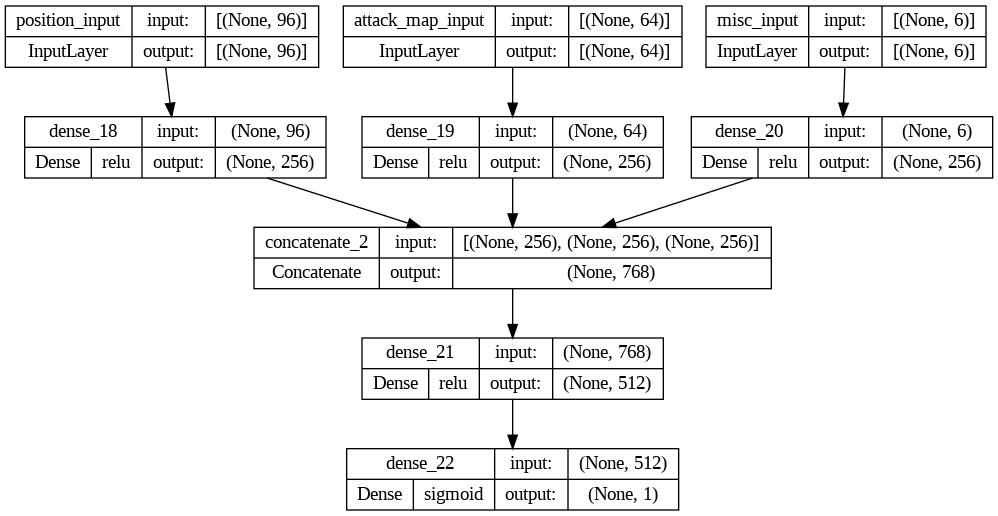

In [22]:
input_shapes = modelinput.ModelInput('all').input_length()

position_input = keras.layers.Input(shape=int(input_shapes[0]), name='position_input')
attacks_input = keras.layers.Input(shape=int(input_shapes[1]), name='attack_map_input')
misc_inputs = keras.layers.Input(shape=int(input_shapes[2]), name='misc_input')

position_dense = keras.layers.Dense(256, activation='relu')(position_input)
attacks_dense = keras.layers.Dense(256, activation='relu')(attacks_input)
misc_dense = keras.layers.Dense(256, activation='relu')(misc_inputs)
x = keras.layers.Concatenate()([position_dense, attacks_dense, misc_dense])
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)

triple_input_model = keras.models.Model(inputs=[position_input, attacks_input, misc_inputs], outputs=x)

triple_input_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
	metrics=[keras.metrics.MeanAbsoluteError()]
)

keras.utils.plot_model(triple_input_model, show_shapes=True, show_layer_activations=True, to_file='triple_input_model.png')

## Training the Models

In [15]:
def train_model(model, training_data, validation_data, save_to):
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        restore_best_weights=True,
        patience=5,
        verbose=1)

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=1,
        min_lr=0.000000000001,
        verbose=1)

    checkpoint = keras.callbacks.ModelCheckpoint(
        f'{save_to}/model',
        monitor='val_loss',
        save_best_only=True)

    tensorboard = keras.callbacks.TensorBoard(
        log_dir=f'{save_to}/logs',
        write_graph=True,
        write_images=True,
        histogram_freq=1)

    model.fit(
        training_data,
        epochs=128,
        validation_data=validation_data,
        callbacks=[early_stopping, reduce_lr, checkpoint, tensorboard])

### Training the single input model

In [20]:
save_to = f'{data_directory}/single_input_model'
if not os.path.exists(save_to):
    os.makedirs(save_to)

train_model(single_input_model, single_input_training_data, single_input_validation_data, save_to)

Epoch 1/128
3125/3125 [==============================] - 15s 5ms/step - loss: 0.0779 - mean_absolute_error: 0.2344 - val_loss: 0.0744 - val_mean_absolute_error: 0.2250 - lr: 0.0010
Epoch 2/128
3122/3125 [============================>.] - ETA: 0s - loss: 0.0725 - mean_absolute_error: 0.2226
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
3125/3125 [==============================] - 17s 5ms/step - loss: 0.0725 - mean_absolute_error: 0.2226 - val_loss: 0.0765 - val_mean_absolute_error: 0.2263 - lr: 0.0010
Epoch 3/128
3125/3125 [==============================] - 41s 13ms/step - loss: 0.0670 - mean_absolute_error: 0.2105 - val_loss: 0.0694 - val_mean_absolute_error: 0.2131 - lr: 2.0000e-04
Epoch 4/128
3125/3125 [==============================] - 15s 5ms/step - loss: 0.0648 - mean_absolute_error: 0.2058 - val_loss: 0.0684 - val_mean_absolute_error: 0.2129 - lr: 2.0000e-04
Epoch 5/128
3125/3125 [==============================] - 14s 5ms/step - loss: 0.0626 - mean_

### Training the triple input model

In [23]:
save_to = f'{data_directory}/triple_input_model'
if not os.path.exists(save_to):
    os.makedirs(save_to)

train_model(triple_input_model, triple_input_training_data, triple_input_validation_data, save_to)

Epoch 1/128
3125/3125 [==============================] - 18s 5ms/step - loss: 0.0714 - mean_absolute_error: 0.2192 - val_loss: 0.0701 - val_mean_absolute_error: 0.2129 - lr: 0.0010
Epoch 2/128
3125/3125 [==============================] - 15s 5ms/step - loss: 0.0652 - mean_absolute_error: 0.2064 - val_loss: 0.0643 - val_mean_absolute_error: 0.2057 - lr: 0.0010
Epoch 3/128
3125/3125 [==============================] - 17s 5ms/step - loss: 0.0609 - mean_absolute_error: 0.1973 - val_loss: 0.0623 - val_mean_absolute_error: 0.1974 - lr: 0.0010
Epoch 4/128
3125/3125 [==============================] - 18s 6ms/step - loss: 0.0578 - mean_absolute_error: 0.1909 - val_loss: 0.0601 - val_mean_absolute_error: 0.1945 - lr: 0.0010
Epoch 5/128
3125/3125 [==============================] - 16s 5ms/step - loss: 0.0542 - mean_absolute_error: 0.1836 - val_loss: 0.0599 - val_mean_absolute_error: 0.1909 - lr: 0.0010
Epoch 6/128
3125/3125 [==============================] - 16s 5ms/step - loss: 0.0516 - mean_abs

## Model evaluation and comparison

### Optionally load previous models

In [34]:
single_input_model = keras.models.load_model(f'{data_directory}/single_input_model/model')
triple_input_model = keras.models.load_model(f'{data_directory}/triple_input_model/model')

### Predictions

In [35]:
def evaluate_model_and_plot_predictions(model, testing_data):
    print('Model Evaluation:')
    evaluation = model.evaluate(testing_data)
    predictions = model.predict(testing_data)

    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    ax[0].hist(predictions, bins=50)
    ax[0].set_title(f'Predicted labels')
    ax[0].set_xlabel('label (y)')
    ax[0].set_ylabel('no. of occurences in dataset')
    ax[1].hist(testing_data.y, bins=50)
    ax[1].set_title(f'Actual labels')
    ax[1].set_xlabel('label (y)')
    ax[1].set_ylabel('no. of occurences in dataset')
    plt.show()

    return predictions

#### For single input model

Thread 0 completed processing 12500 samples.Model Evaluation:
12500/12500 [==============================] - 24s 2ms/step


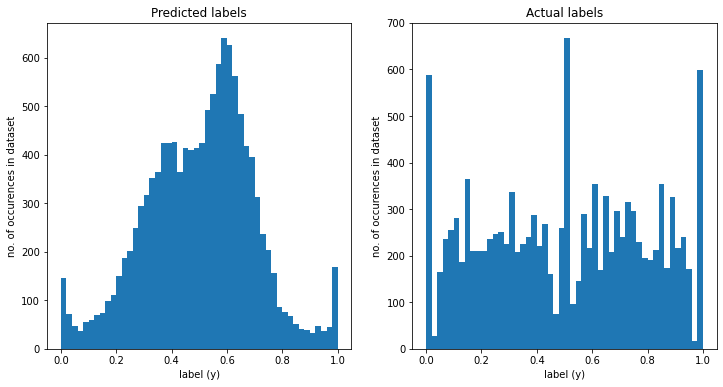

In [36]:
single_input_testing_data = DataGenerator(data_directory + '/test_set.npz', 'positions', batch_size=1)
single_input_predictions = evaluate_model_and_plot_predictions(single_input_model, single_input_testing_data)

#### For triple input model

Thread 0 completed processing 12500 samples.Model Evaluation:
12500/12500 [==============================] - 27s 2ms/step


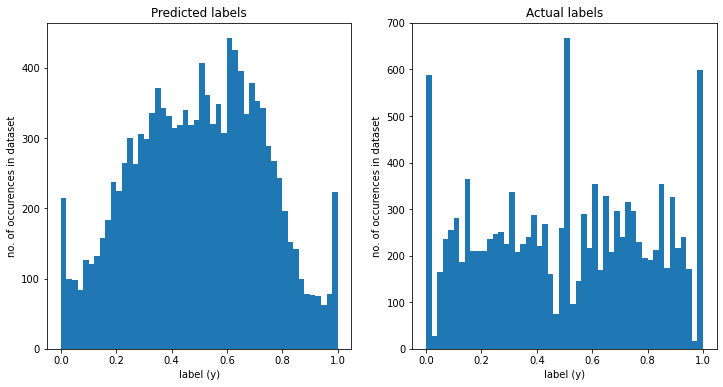

In [37]:
triple_input_testing_data = DataGenerator(data_directory + '/test_set.npz', 'all', batch_size=1)
triple_input_predictions = evaluate_model_and_plot_predictions(triple_input_model, triple_input_testing_data)

### Confusion Matrices

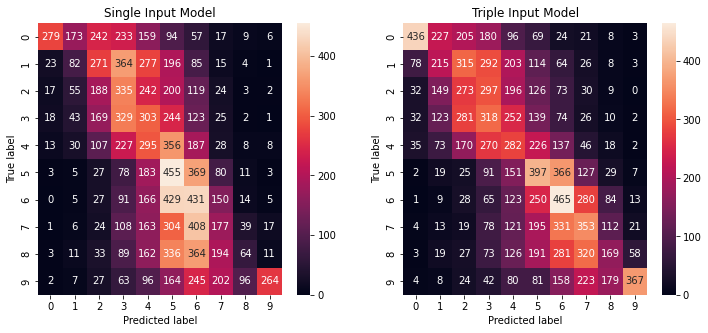

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(predictions, testing_data, ax):
    # Bin the data into continuous intervals, then plot a confusion matrix
    predictions_binned = np.digitize(predictions, bins=np.linspace(0, 1.01, 11))
    y_binned = np.digitize(testing_data.y, bins=np.linspace(0, 1.01, 11))
    cm = confusion_matrix(y_binned, predictions_binned)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plot_confusion_matrix(single_input_predictions, single_input_testing_data, ax[0])
plot_confusion_matrix(triple_input_predictions, triple_input_testing_data, ax[1])

ax[0].set(xlabel='Predicted label', ylabel='True label', title='Single Input Model')
ax[1].set(xlabel='Predicted label', ylabel='True label', title='Triple Input Model')

plt.show()